<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/6_PatchTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

This demo requires Hugging Face [`Transformers`](https://github.com/huggingface/transformers) for the model, and the IBM `tsfm` package for auxiliary data pre-processing.
We can install both by cloning the `tsfm` repository and following the below steps.


😈 **Task 1:** Explore what `PatchTST` offers compared to traditional transformers. What’s unique about the patching mechanism?


1. Clone the public IBM Time Series Foundation Model Repository [`tsfm`](https://github.com/ibm/tsfm).

2. Install Hugging Face [`Transformers`](https://github.com/huggingface/transformers#installation)

3. Test it with the following commands in a `python` terminal.


In [2]:
#!pip install git+https://github.com/IBM/tsfm.git transformers tf_keras gdown

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU
from transformers import PatchTSTConfig
from tsfm_public.toolkit.dataset import ForecastDFDataset

/home/philipp/Documents/mless/venv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-17 12:19:45.973235: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-17 12:19:45.979514: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-17 12:19:46.024792: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-17 12:19:46.066487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to

## Part 1: Forecasting on the TOAR dataset
Here we train a `PatchTST` model directly on the TOAR normalized data similar to TOAR huggingface example and evaluate its performance.

😈 **Question 1:** Why might a transformer model be well-suited for air quality forecasting?

😈 **Task 2:** Compare PatchTST against LSTM or MLP. What trends do you notice?


In [4]:
# Standard
import os

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSTConfig,
    PatchTSTForPrediction,
    set_seed,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

# supress some warnings
import warnings

warnings.filterwarnings("ignore", module="torch")

### Set seed

😈 **Task 3:** Try changing the seed and observe if training results vary significantly.


In [5]:
set_seed(2025)

### Load and prepare datasets

 In the next cell, please adjust the following parameters to suit your application:
 - `dataset_path`: path to local .csv file, or web address to a csv file for the data of interest. Data is loaded with pandas, so anything supported by
   `pd.read_csv` is supported: (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
 - `timestamp_column`: column name containing timestamp information, use `None` if there is no such column.
 - `id_columns`: List of column names specifying the IDs of different time series. If no ID column exists, use `[]`.
 - `forecast_columns`: List of columns to be modeled
 - `context_length`: The amount of historical data used as input to the model. Windows of the input time series data with length equal to `context_length` will be extracted from the input dataframe. In the case of a multi-time series dataset, the context windows will be created so that they are contained within a single time series (i.e., a single ID).
 - `forecast_horizon`: Number of timestamps to forecast in the future.
 - `train_start_index`, `train_end_index`: the start and end indices in the loaded data which delineate the training data.
 - `valid_start_index`, `eval_end_index`: the start and end indices in the loaded data which delineate the validation data.
 - `test_start_index`, `eval_end_index`: the start and end indices in the loaded data which delineate the test data.
 - `patch_length`: The patch length for the `PatchTST` model. It is recommended to choose a value that evenly divides `context_length`.
 - `num_workers`: Number of CPU workers in the PyTorch dataloader.
 - `batch_size`: Batch size.

The data is first loaded into a Pandas dataframe and split into training, validation, and test parts. Then the Pandas dataframes are converted to the appropriate PyTorch dataset required for training.

😈 **Task 4:** Change `context_length` or `patch_length` and compare validation loss.

😈 **Question 2:** Why does `patch_length` need to divide `context_length` evenly?


In [6]:
import gdown
import pandas as pd
import pickle
import numpy as np
import os
import torch

# Load the pkl files that contain the same preprocessed data as other models
with open("./X_train_corrected.pkl", "rb") as f:
    X_train_full = pickle.load(f)

with open("./X_test_corrected.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open("./y_train_corrected.pkl", "rb") as f:
    y_train_full = pickle.load(f) 

with open("./y_test_corrected.pkl", "rb") as f:
    y_test_full = pickle.load(f)

print(f"Loaded pkl data shapes:")
print(f"X_train_full: {X_train_full.shape}, y_train_full: {y_train_full.shape}")
print(f"X_test_full: {X_test_full.shape}, y_test_full: {y_test_full.shape}")

# Now read the downloaded file
data = pd.read_csv("./timeseries_data/normalized_data_DOWNLOADED.csv", parse_dates=["datetime"])
print(data.head())

timestamp_column = "datetime"
id_columns = ['station_code','latitude','longitude']

context_length = 336
forecast_horizon = 96
patch_length = 16
num_workers = 16  # Reduce this if you have low number of CPU cores
batch_size = 64  # Adjust according to GPU memory

observable_columns = ["temp"] #["no2", "temp", "o3", "no", "press"]
target_columns = observable_columns #["o3"]

Loaded pkl data shapes:
X_train_full: (427357, 336, 2), y_train_full: (427357, 96, 2)
X_test_full: (106841, 336, 2), y_test_full: (106841, 96, 2)
   longitude   latitude station_code                  datetime      temp
0   7.567796  47.819182      DEBW073 1997-01-01 00:00:00+00:00 -2.564191
1   7.567796  47.819182      DEBW073 1997-01-01 01:00:00+00:00 -2.686422
2   7.567796  47.819182      DEBW073 1997-01-01 02:00:00+00:00 -2.686422
3   7.567796  47.819182      DEBW073 1997-01-01 03:00:00+00:00 -2.808654
4   7.567796  47.819182      DEBW073 1997-01-01 04:00:00+00:00 -2.808654


In [7]:
print("=== Multi-Station Training Setup ===")
print(f"X_train_full shape: {X_train_full.shape}")
print(f"Unique stations: {np.unique(X_train_full[:, 0, 0])}")

# UPDATED: Train on ALL stations (like MLP/LSTM) instead of single station
# Extract temp variable (column 1 = variable values, column 0 = station codes)
temp_var_idx = 1

# Use ALL training data across all stations
X_train_temp = X_train_full[:, :, temp_var_idx].astype(np.float32)
y_train_temp = y_train_full[:, :, temp_var_idx].astype(np.float32)
X_test_temp = X_test_full[:, :, temp_var_idx].astype(np.float32) 
y_test_temp = y_test_full[:, :, temp_var_idx].astype(np.float32)

print(f"Training on ALL stations:")
print(f"X_train_temp: {X_train_temp.shape}, y_train_temp: {y_train_temp.shape}")
print(f"X_test_temp: {X_test_temp.shape}, y_test_temp: {y_test_temp.shape}")

# Verify data statistics match expected normalization (should be ~N(0,1))
print(f"Data statistics check:")
print(f"X_train_temp - mean: {X_train_temp.mean():.4f}, std: {X_train_temp.std():.4f}")
print(f"y_train_temp - mean: {y_train_temp.mean():.4f}, std: {y_train_temp.std():.4f}")

# Create train/validation split (80/20) from the multi-station training data
n_samples = len(X_train_temp)
n_train = int(n_samples * 0.8)
n_valid = n_samples - n_train

X_train_split = X_train_temp[:n_train]
y_train_split = y_train_temp[:n_train]
X_valid_split = X_train_temp[n_train:]
y_valid_split = y_train_temp[n_train:]

print(f"\nFinal dataset splits (multi-station):")
print(f"Train: X={X_train_split.shape}, y={y_train_split.shape}")
print(f"Valid: X={X_valid_split.shape}, y={y_valid_split.shape}")
print(f"Test: X={X_test_temp.shape}, y={y_test_temp.shape}")

# Sample first few values to verify they look reasonable
print(f"\nData sanity check - first 5 context values:")
print(f"X_train_split[0][:5]: {X_train_split[0][:5]}")
print(f"y_train_split[0][:5]: {y_train_split[0][:5]}")

# Create scaler_stats for denormalization (based on original data)
data_temp_subset = data[data['station_code'].isin(['DEBW073', 'DEHE020', 'DENW094'])]
scaler_stats = {col: {'mean': data_temp_subset[col].mean(), 'std': data_temp_subset[col].std()} for col in observable_columns}
print(f"Scaler stats for denormalization: {scaler_stats}")

data['station_code'].unique()

=== Multi-Station Training Setup ===
X_train_full shape: (427357, 336, 2)
Unique stations: ['DEBW073' 'DEHE020' 'DENW094']
Training on ALL stations:
X_train_temp: (427357, 336), y_train_temp: (427357, 96)
X_test_temp: (106841, 336), y_test_temp: (106841, 96)
Data statistics check:
X_train_temp - mean: 0.0058, std: 1.0036
y_train_temp - mean: 0.0119, std: 1.0013

Final dataset splits (multi-station):
Train: X=(341885, 336), y=(341885, 96)
Valid: X=(85472, 336), y=(85472, 96)
Test: X=(106841, 336), y=(106841, 96)

Data sanity check - first 5 context values:
X_train_split[0][:5]: [-3.6261468 -3.6948187 -3.7085533 -3.8046942 -3.832163 ]
y_train_split[0][:5]: [-1.1539512 -1.250092  -1.1539512 -1.18142   -1.1676855]
Scaler stats for denormalization: {'temp': {'mean': -1.2556011621079978e-17, 'std': 0.999998274310436}}


array(['DEBW073', 'DEHE020', 'DENW094'], dtype=object)

In [8]:
# Create custom datasets directly from pkl data without TimeSeriesPreprocessor
# since the data is already properly normalized and sequenced

class PickleDataset:
    """Custom dataset that works with pkl data format for PatchTST"""
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        # PatchTST expects past_values and future_values as tensors
        # X_data shape: (n_samples, context_length) -> (context_length, 1)
        # y_data shape: (n_samples, forecast_horizon) -> (forecast_horizon, 1)
        
        past_values = torch.tensor(self.X_data[idx], dtype=torch.float32).reshape(-1, 1)
        future_values = torch.tensor(self.y_data[idx], dtype=torch.float32).reshape(-1, 1)
        
        return {
            'past_values': past_values,
            'future_values': future_values
        }

# Create datasets using the pkl data
train_dataset = PickleDataset(X_train_split, y_train_split)
valid_dataset = PickleDataset(X_valid_split, y_valid_split)
test_dataset = PickleDataset(X_test_temp, y_test_temp)

print(f"Created datasets:")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Test the dataset format
sample = train_dataset[0]
print(f"Sample data shapes:")
print(f"past_values: {sample['past_values'].shape}")
print(f"future_values: {sample['future_values'].shape}")

# Keep data reference for potential denormalization later
data = data[data['station_code'] == "DENW094"]
data['latitude'] = data['latitude'].astype(int)
data['longitude'] = data['longitude'].astype(int)

Created datasets:
Train dataset size: 341885
Valid dataset size: 85472
Test dataset size: 106841
Sample data shapes:
past_values: torch.Size([336, 1])
future_values: torch.Size([96, 1])


Note: Input and output columns have been renamed target and observable columns in the newer version of tsfm not reflected in huggingface notebook

😈 **Task 5:** Update the code to reflect `tsfm`’s new naming and ensure compatibility.


In [9]:
# Datasets are already created in the previous cell using PickleDataset
# This ensures PatchTST uses the same normalized data as LSTM, MLP, and other models
# No additional dataset creation needed since we're working directly with pkl files

print("Using pkl-based datasets for consistent normalization across all models")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")  
print(f"Test samples: {len(test_dataset)}")

# Verify the data format matches PatchTST expectations
sample_batch = train_dataset[0]
print(f"Sample input shape (past_values): {sample_batch['past_values'].shape}")
print(f"Sample target shape (future_values): {sample_batch['future_values'].shape}")
print(f"Context length: {sample_batch['past_values'].shape[0]}")
print(f"Forecast horizon: {sample_batch['future_values'].shape[0]}")
print(f"Number of channels: {sample_batch['past_values'].shape[1]}")

Using pkl-based datasets for consistent normalization across all models
Train samples: 341885
Validation samples: 85472
Test samples: 106841
Sample input shape (past_values): torch.Size([336, 1])
Sample target shape (future_values): torch.Size([96, 1])
Context length: 336
Forecast horizon: 96
Number of channels: 1


### Configure the PatchTST model

Next, we instantiate a randomly initialized `PatchTST` model with a configuration. The settings below control the different hyperparameters related to the architecture.
  - `num_input_channels`: the number of input channels (or dimensions) in the time series data. This is
    automatically set to the number for forecast columns.
  - `context_length`: As described above, the amount of historical data used as input to the model.
  - `patch_length`: The length of the patches extracted from the context window (of length `context_length`).
  - `patch_stride`: The stride used when extracting patches from the context window.
  - `random_mask_ratio`: The fraction of input patches that are completely masked for pretraining the model.
  - `d_model`: Dimension of the transformer layers.
  - `num_attention_heads`: The number of attention heads for each attention layer in the Transformer encoder.
  - `num_hidden_layers`: The number of encoder layers.
  - `ffn_dim`: Dimension of the intermediate (often referred to as feed-forward) layer in the encoder.
  - `dropout`: Dropout probability for all fully connected layers in the encoder.
  - `head_dropout`: Dropout probability used in the head of the model.
  - `pooling_type`: Pooling of the embedding. `"mean"`, `"max"` and `None` are supported.
  - `channel_attention`: Activate the channel attention block in the Transformer to allow channels to attend to each other.
  - `scaling`: Whether to scale the input targets via "mean" scaler, "std" scaler, or no scaler if `None`. If `True`, the
    scaler is set to `"mean"`.
  - `loss`: The loss function for the model corresponding to the `distribution_output` head. For parametric
    distributions it is the negative log-likelihood (`"nll"`) and for point estimates it is the mean squared
    error `"mse"`.
  - `pre_norm`: Normalization is applied before self-attention if pre_norm is set to `True`. Otherwise, normalization is
    applied after residual block.
  - `norm_type`: Normalization at each Transformer layer. Can be `"BatchNorm"` or `"LayerNorm"`.

For full details on the parameters, we refer to the [documentation](https://huggingface.co/docs/transformers/main/en/model_doc/patchtst#transformers.PatchTSTConfig).

😈 **Task 6:** Test `dropout`, `d_model`, and `num_attention_heads` variations to understand their impact.

😈 **Question 3:** What’s the difference between `LayerNorm` and `BatchNorm`, and when might one be preferred over the other?



In [10]:
config = PatchTSTConfig(
    num_input_channels=len(observable_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.4,
    d_model=128,
    num_attention_heads=16,
    num_hidden_layers=3,
    ffn_dim=256,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling=None,  # CHANGED: Disable scaling since pkl data is already normalized
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm",
)
model = PatchTSTForPrediction(config)

### Optional
 if you would like to use wandb

😈 **Task 7:** Log additional metrics like MAE or custom visualizations in wandb.


In [11]:
#!export WANDB_API_KEY=

### Train model

Next, we can leverage the Hugging Face [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class to train the model based on the direct forecasting strategy. We first define the [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) which lists various hyperparameters for training such as the number of epochs, learning rate and so on.

😈 **Task 8:** Implement early stopping. How does it affect training duration and validation loss?


In [12]:
training_args = TrainingArguments(
    output_dir="./checkpoint/patchtst/TOAR/pretrain/output/",
    overwrite_output_dir=True,
    # learning_rate=0.001,
    num_train_epochs=10,
    do_eval=True,
    eval_strategy="epoch", # previously evaluation_strategy
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="./checkpoint/patchtst/TOAR/pretrain/logs/",  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
    # Force CPU usage
    no_cuda=True,
    use_cpu=True,
    # Disable distributed training
    local_rank=-1,
    ddp_find_unused_parameters=False,
    ddp_backend=None,
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

/home/philipp/Documents/mless/venv310/lib/python3.10/site-packages/transformers/training_args.py:1577: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [13]:
# pretrain
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: philippkk (philippkk-test) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.217600,0.179765
2,0.195800,0.176923
3,0.189400,0.179447
4,0.182800,0.178334
5,0.175500,0.178676


TrainOutput(global_step=26710, training_loss=0.19224492469024942, metrics={'train_runtime': 519.0981, 'train_samples_per_second': 6586.135, 'train_steps_per_second': 102.909, 'total_flos': 2276036425958400.0, 'train_loss': 0.19224492469024942, 'epoch': 5.0})

### Evaluate the model on the test set of the source domain

Next, we can leverage `trainer.evaluate()` to calculate test metrics. While this is not the target metric to judge in this task, it provides a reasonable check that the pretrained model has trained properly.
Note that the training and evaluation loss for `PatchTST` is the Mean Squared Error (MSE) loss. Hence, we do not separately compute the MSE metric in any of the following evaluation experiments.

😈 **Task 9:** Visualize forecast vs. actual values to visually inspect quality.

😈 **Question 4:** What are the limitations of using only MSE for evaluation?


In [14]:
results = trainer.evaluate(test_dataset)
print("Test result:")
print(results)

Test result:
{'eval_loss': 0.19971847534179688, 'eval_runtime': 10.9846, 'eval_samples_per_second': 9726.46, 'eval_steps_per_second': 152.031, 'epoch': 5.0}


### Save model

😈 **Task 10:** Save multiple checkpoints and compare predictions from different training stages.


In [15]:
save_dir = "./checkpoint/patchtst/TOAR/model/pretrain/"
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)

## Reload Trained Model

😈 **Task 11:** Load a saved model and apply it to a completely new station’s dataset.


In [16]:
#!mkdir -p checkpoint

#!gdown --folder https://drive.google.com/drive/folders/1XKxWaY_Zw0b1skeDlrMeh66aO1UVYPY -O checkpoint

In [17]:
## Pre trained checkpoint files can be loaded from below url:
# https://drive.google.com/drive/folders/1XKxWaY_Zw0b1skeDlrMeh66aO1UVYPY-?usp=drive_link
trained_forecast_model = PatchTSTForPrediction.from_pretrained(
    "./checkpoint/patchtst/TOAR/model/pretrain/",
    num_input_channels=len(observable_columns),
    dropout=0.7,
    head_dropout=0.7,
)
## make sure the othervariables are recreated from cells before pretraining
re_trainer = Trainer(
    model=trained_forecast_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
)

## Predict and Plot

😈 **Task 12:** Compare predictions across stations. Which station is easier to forecast and why?


In [18]:
raw_predictions = re_trainer.predict(test_dataset)
patchtst_predictions = raw_predictions.predictions
patchtst_predictions = patchtst_predictions[0]  # Extract the actual predictions array
patchtst_predictions.shape

(106841, 96, 1)

### Comparability


> Plotting in line with MLP and LSTM

😈 **Question 5:** What benefits do attention-based models offer over recurrent models in forecasting scenarios?



In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Plot

😈 **Task 13:** Add confidence intervals or highlight anomalies in the prediction plots.


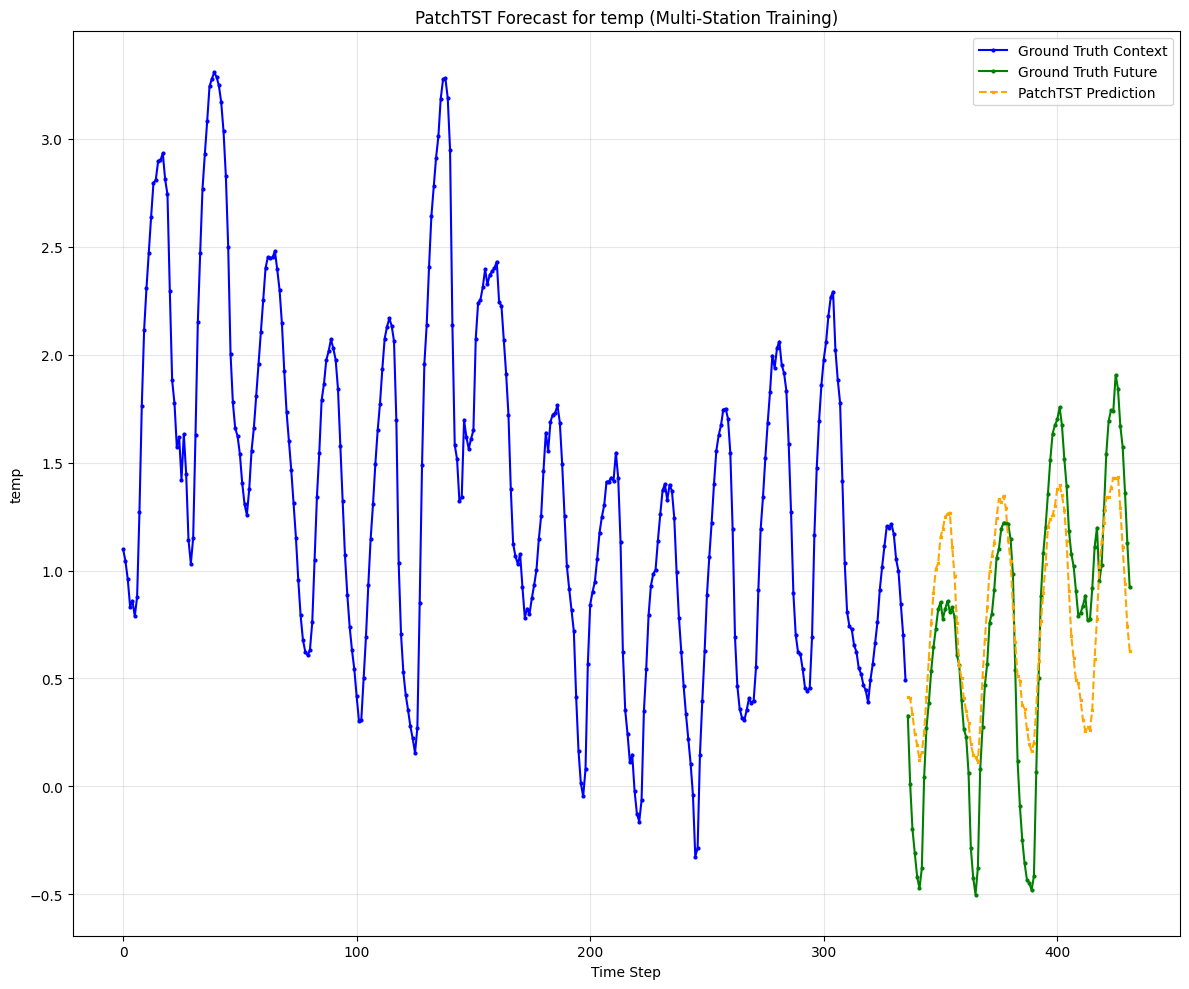

PatchTST Test MSE: 0.1395
PatchTST Test RMSE: 0.3734


In [20]:
observable_columnss = ["temp"]
context_window = 336
prediction_horizon = 96

plt.figure(figsize=(12, 10))
num_variables = len(observable_columnss)

for variable_idx in range(num_variables):
    sample_idx = 0

    # FIXED: Use scaler_stats instead of test_data for denormalization
    context = (test_dataset[sample_idx]['past_values'] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']).detach().numpy().flatten()
    actual_future = (test_dataset[sample_idx]['future_values'] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']).detach().numpy().flatten()
    predicted_future = patchtst_predictions[sample_idx, :, variable_idx] * scaler_stats['temp']['std'] + scaler_stats['temp']['mean']
    
    # Plot
    plt.subplot(num_variables, 1, variable_idx + 1)

    plt.plot(range(context_window), context, label="Ground Truth Context", color="blue", marker="o", markersize=2)
    plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Ground Truth Future", color="green", marker="o", markersize=2)
    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="PatchTST Prediction", linestyle="--", color="orange", marker="x", markersize=2)

    plt.title(f"PatchTST Forecast for {observable_columnss[variable_idx]} (Multi-Station Training)")
    plt.xlabel("Time Step")
    plt.ylabel(observable_columnss[variable_idx])
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display metrics
mse = mean_squared_error(actual_future, predicted_future)
print(f"PatchTST Test MSE: {mse:.4f}")
print(f"PatchTST Test RMSE: {np.sqrt(mse):.4f}")


# Extra
If you want to load the custom sampled data from drive for plots comparability.

In [21]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
observable_columnss = ["temp"]#["no2", "temp", "o3", "no", "press"]
context_window = 336
prediction_horizon = 96
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# Please download the files and place them in content subfolder
# else modify below path according to your chosen local download path:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Flatten input features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(observable_columns))  # (samples, 24*5)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(observable_columns))
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1],  len(observable_columns))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(observable_columns))

scaler_stats = {col: {'mean': data[col].mean(), 'std': data[col].std()} for col in observable_columnss}

# Flatten input features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(observable_columns))  # (samples, 24*5)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(observable_columns))
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1],  len(observable_columns))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(observable_columns))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

In [ ]:
raw_predictions = re_trainer.predict(X_test)
patchtst_predictions = raw_predictions.predictions
patchtst_predictions = patchtst_predictions[0]  # Extract the actual predictions array
patchtst_predictions.shape